# Machine Translation Project: English to French (Europarl v8)

## Project Overview
In this project, we aim to build and evaluate machine translation models to translate text from **English to French**. We utilize the **Europarl v8** dataset, which consists of parallel texts extracted from the proceedings of the European Parliament.

The goal of this notebook is to understand the dataset, split sizes, and token distributions.


### *Authors* : Maxime HAYAKAWA IVANOVIC, Kenichi Juan SUTAN, Amine OUTMANI 

# 1. Data loading & visualization

First, we set up the environment by defining the file paths for the dataset. We use `pathlib` to ensure the paths work across different operating systems and verify that both the English (Source) and French (Target) files are accessible.

In [2]:
from pathlib import Path
from collections import defaultdict
import re

# 1. Setup Paths
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

# Define the specific files you have
EN_PATH = DATA_DIR / "Europarl.en-fr.en"
FR_PATH = DATA_DIR / "Europarl.en-fr.fr"

# Verify they exist
if EN_PATH.exists() and FR_PATH.exists():
    print(f"Found English file: {EN_PATH.name}")
    print(f"Found French file:  {FR_PATH.name}")
else:
    print("Error: Files not found. Check your folder structure.")

Found English file: Europarl.en-fr.en
Found French file:  Europarl.en-fr.fr


### Loading Data 

We adapt our loading function to return a **Pandas DataFrame**, which offers advantages such as handling large tables more efficiently than standard Python lists.

The function reads the files line-by-line to ensure safety and alignment, filters out empty lines, and then converts the result into a structured DataFrame.

In [3]:
import pandas as pd

def load_parallel_subset(en_path, fr_path, max_lines):
    """
    Reads two aligned text files and returns a Pandas DataFrame with columns ['en', 'fr'].
    """
    pairs = []
    
    try:
        # Open both files at the same time
        with open(en_path, "r", encoding="utf-8") as f_en, \
             open(fr_path, "r", encoding="utf-8") as f_fr:
            
            # zip() pairs lines together safely
            for i, (line_en, line_fr) in enumerate(zip(f_en, f_fr)):
                if i >= max_lines:
                    break
                
                text_en = line_en.strip()
                text_fr = line_fr.strip()
                
                # Only keep if both sides have content
                if text_en and text_fr:
                    pairs.append((text_en, text_fr))
                    
    except Exception as e:
        print(f"Error reading files: {e}")
        return pd.DataFrame()  # Return empty DF on error

    # Convert list of tuples to DataFrame
    df = pd.DataFrame(pairs, columns=["en", "fr"])
    return df

In [4]:
subset_size = 500000

In [5]:
# Run the loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)
print(f"Successfully loaded {len(df)} pairs.")

Successfully loaded 500000 pairs.


### Quick look on some samples (`k` random ones)

In [6]:
import pandas as pd

def sample_pairs(df, k):
    """Print k random sample pairs from a DataFrame."""
    if df.empty:
        print("DataFrame is empty.")
        return

    # Use min() to ensure we don't sample more rows than exist
    sample_df = df.sample(n=min(k, len(df)))

    print("\n=== Sample pairs ===")
    
    # Iterate over the sampled rows
    for i, row in enumerate(sample_df.itertuples(), 1):
        en_text = row.en
        fr_text = row.fr
        
        print(f"--- Pair {i} ---")
        print(f"EN: {en_text[:200]}{'...' if len(en_text) > 200 else ''}")
        print(f"FR: {fr_text[:200]}{'...' if len(fr_text) > 200 else ''}")
        print()

In [7]:
nb_samples = 7

In [8]:
sample_pairs(df, nb_samples)


=== Sample pairs ===
--- Pair 1 ---
EN: What we proposed, let me repeat, is one Commissioner per Member State, but with two options. I would like you to consider these options carefully, and indeed we have the time to carefully consider the...
FR: Ce que nous avons proposé, je le redis, c'est qu'il y ait un commissaire par État membre, mais selon deux options auxquelles je vous demande de bien réfléchir et nous avons le temps de bien réfléchir ...

--- Pair 2 ---
EN: It includes powerful countries which have been colonial powers in the past.
FR: Nous avons un passé de puissance coloniale.

--- Pair 3 ---
EN: It is also worth addressing some of the concerns which my fellow Member, Baroness Ludford, expressed about pre-emptive strikes.
FR: Les inquiétudes exprimées par ma collègue Mme Ludford à propos des frappes préventives méritent également notre attention.

--- Pair 4 ---
EN: This coincidence is curious but it does not alter the fact that the Galileo project is very important, and s

### Exploratory Data Analysis: Basic Statistics

We compute basic statistics to understand the length distribution of our parallel sentences. 

**Important Decisions:**
* **Stopwords:** We **do not** remove stopwords. In Machine Translation, function words (like "le", "de", "the", "to") are critical for constructing grammatically correct sentences in the target language.
* **Tokenization:** For this initial analysis, we use simple whitespace splitting to approximate word counts.  
* **Efficiency:** We utilize Pandas vectorization to compute lengths across the entire dataset instantly.

In [9]:
import numpy as np

def basic_stats(df):
    """
    Computes and prints basic statistics using Pandas for efficiency.
    """
    if df.empty:
        print("No data loaded.")
        return {}

    # 1. Compute lengths (Vectorized)
    # Character counts
    df['en_char_len'] = df['en'].str.len()
    df['fr_char_len'] = df['fr'].str.len()
    
    # Word counts (approximate using split)
    df['en_word_len'] = df['en'].str.split().str.len()
    df['fr_word_len'] = df['fr'].str.split().str.len()

    # 2. Compute aggregations
    stats = {
        "n_pairs": len(df),
        "en_total_chars": df['en_char_len'].sum(),  
        "fr_total_chars": df['fr_char_len'].sum(),  
        "en_char_mean": df['en_char_len'].mean(),
        "fr_char_mean": df['fr_char_len'].mean(),
        "en_word_mean": df['en_word_len'].mean(),
        "fr_word_mean": df['fr_word_len'].mean(),
        "en_char_min": df['en_char_len'].min(),
        "en_char_max": df['en_char_len'].max(),
        "fr_char_min": df['fr_char_len'].min(),
        "fr_char_max": df['fr_char_len'].max(),
    }

    # 3. Print Results
    print("=== Basic Statistics ===")
    print(f"Number of sentence pairs: {stats['n_pairs']:,}")
    print(f"Total characters (EN):    {stats['en_total_chars']:,}")
    print(f"Total characters (FR):    {stats['fr_total_chars']:,}")
    print(f"English - chars: mean={stats['en_char_mean']:.1f}, min={stats['en_char_min']}, max={stats['en_char_max']}")
    print(f"French  - chars: mean={stats['fr_char_mean']:.1f}, min={stats['fr_char_min']}, max={stats['fr_char_max']}")
    print(f"English - words/sentence: mean={stats['en_word_mean']:.1f}")
    print(f"French  - words/sentence: mean={stats['fr_word_mean']:.1f}")
    
    return stats

In [10]:
print(basic_stats(df))

=== Basic Statistics ===
Number of sentence pairs: 500,000
Total characters (EN):    75,734,431
Total characters (FR):    83,610,771
English - chars: mean=151.5, min=1, max=1871
French  - chars: mean=167.2, min=1, max=1459
English - words/sentence: mean=25.5
French  - words/sentence: mean=26.6
{'n_pairs': 500000, 'en_total_chars': np.int64(75734431), 'fr_total_chars': np.int64(83610771), 'en_char_mean': np.float64(151.468862), 'fr_char_mean': np.float64(167.221542), 'en_word_mean': np.float64(25.516568), 'fr_word_mean': np.float64(26.591636), 'en_char_min': np.int64(1), 'en_char_max': np.int64(1871), 'fr_char_min': np.int64(1), 'fr_char_max': np.int64(1459)}


Based on 500,000 sentence pairs, we observe the following characteristics:

* **Text Expansion:** French sentences are consistently longer than their English counterparts. On average, French segments have **~167 characters** compared to **~151 for English** (roughly **10% longer** in characters). This aligns with the linguistic expectation that French is generally more verbose than English.
* **Sequence Length:** The average sentence length is around **25-27 words**. 
* **Outliers:**
    * **Max Length:** The maximum English sentence length is **1,871 characters** (and 1,459 for French). These extremely long sequences are likely parsing errors or lists within the parliamentary proceedings. They will need to be filtered out to avoid memory issues during training.
    * **Min Length:** The minimum length of **1** suggests noise (e.g., isolated punctuation or numbering). These should also be removed.

**Conclusion:** We should implement a filtering step to remove sentences that are too long (e.g., > 100 words) or too short, ensuring our model trains on high-quality sentence pairs.

### Character Frequency Analysis

**Why do we do this?**
* To identify the **language** (French will have `é`, `à`, `ç`, `œ`).
* To spot **artifacts** (encoding errors like `Ã©`, weird symbols, or HTML leftovers).
* To fingerprint the **domain** (Math symbols? Emojis in informal text? We expect mostly alphabet and punctuation here).

We analyze the character distribution for both languages.

Sampling 20000 sentences for character analysis...


C:\Users\User\AppData\Local\Temp\ipykernel_3748\230398519.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(chars, rotation=0) # Keep rotation 0 for single chars
C:\Users\User\AppData\Local\Temp\ipykernel_3748\230398519.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(chars, rotation=0) # Keep rotation 0 for single chars


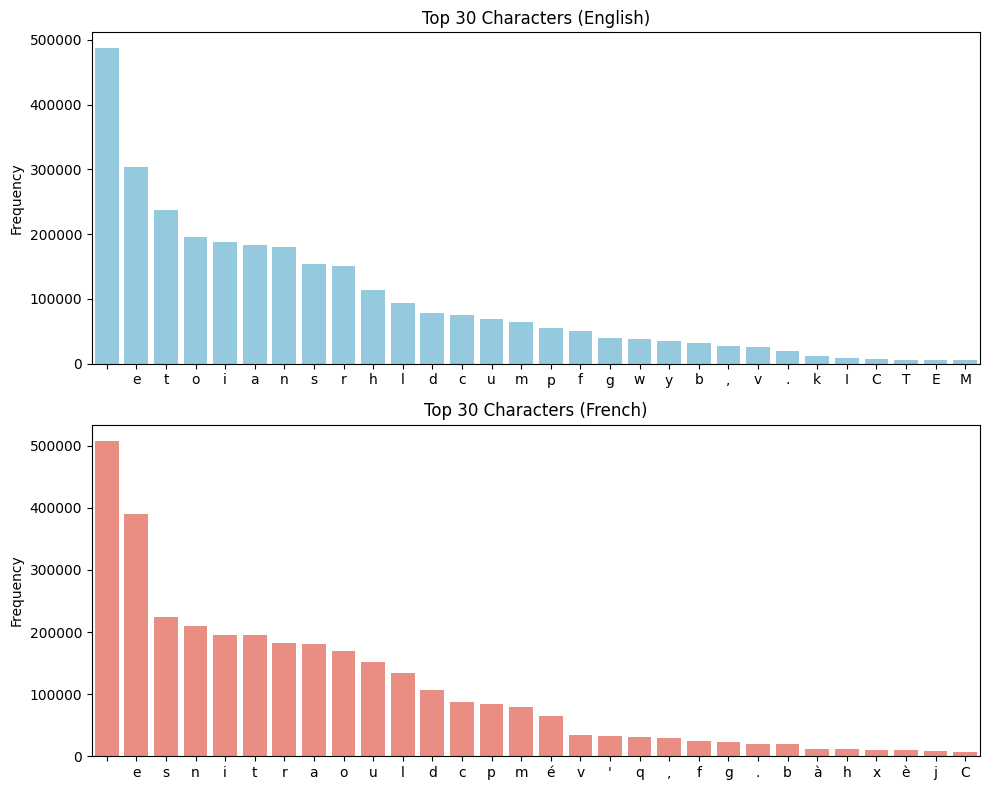


=== Rare Character Check (Bottom 10) ===
EN Rare: [('ã', 1), ('Ó', 1), ('û', 1), ('â', 1), ('¾', 1), ('¡', 1), ('å', 1), ('·', 1), ('£', 2), ('Ü', 2)]
FR Rare: [('ã', 1), ('Ó', 1), ('²', 1), ('Ë', 1), ('Ü', 1), ('¡', 1), ('Ì', 1), ('È', 1), ('Ç', 1), ('å', 1)]


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np

def analyze_character_distribution(df, samples=20000):
    """
    Analyzes character frequency for English and French.
    Uses a random sample for efficiency.
    """
    print(f"Sampling {samples} sentences for character analysis...")
    
    # Aggregate text from a sample
    # We join a subset of lines into one massive string
    subset = df.sample(n=min(len(df), samples), random_state=42)
    text_en = "".join(subset['en'].dropna().astype(str).tolist())
    text_fr = "".join(subset['fr'].dropna().astype(str).tolist())
    
    # Count Characters
    cnt_en = Counter(text_en)
    cnt_fr = Counter(text_fr)
    
    # Visualization: Top 30 Characters
    def plot_top_chars(counter, ax, title, color):
        top_chars = counter.most_common(30)
        chars, freqs = zip(*top_chars)
        
        sns.barplot(x=list(chars), y=list(freqs), ax=ax, color=color)
        ax.set_title(title)
        ax.set_xticklabels(chars, rotation=0) # Keep rotation 0 for single chars
        ax.set_ylabel("Frequency")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    plot_top_chars(cnt_en, ax1, "Top 30 Characters (English)", "skyblue")
    plot_top_chars(cnt_fr, ax2, "Top 30 Characters (French)", "salmon")
    
    plt.tight_layout()
    plt.show()
    
    # 5. Quick Artifact Check
    # Print characters that appear very rarely (potential noise)
    print("\n=== Rare Character Check (Bottom 10) ===")
    print(f"EN Rare: {cnt_en.most_common()[:-11:-1]}")
    print(f"FR Rare: {cnt_fr.most_common()[:-11:-1]}")

# Run the analysis
analyze_character_distribution(df)

### Visualizing Sentence Length Distribution

We visualize the distribution of sentence lengths using **histograms** and **boxplots** side-by-side.

**What this tells us:**
* **Distribution Shape (Left):** The histogram shows that sentence lengths follow a log-normal distribution. We can clearly see the "shift" where French sentences (red) tend to be slightly longer than English sentences (blue).
* **Outliers & Spread (Right):** The boxplot highlights **outliers** (points beyond the whiskers) and compares the **medians** (green lines). This helps us identify extreme values that might need filtering.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentence_length_distribution(df, bins=50):
    """
    Plots the distribution of sentence lengths (word count).
    Generates two separate figures: one for Histograms, one for Boxplots.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Ensure word counts are computed
    if 'en_word_len' not in df.columns:
        df['en_word_len'] = df['en'].str.split().str.len()
        df['fr_word_len'] = df['fr'].str.split().str.len()

    # --- FIGURE 1: HISTOGRAMS ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['en_word_len'], bins=bins, color='blue', alpha=0.4, label='English', kde=True, linewidth=0.4)
    sns.histplot(df['fr_word_len'], bins=bins, color='red', alpha=0.4, label='French', kde=True, linewidth=0.4)
    
    plt.title("Distribution of Sentence Lengths (Histogram)")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- FIGURE 2: BOXPLOTS ---
    plt.figure(figsize=(8, 6))
    
    # Prepare data for boxplot
    plot_df = df[['en_word_len', 'fr_word_len']].rename(
        columns={'en_word_len': 'English', 'fr_word_len': 'French'}
    )
    
    # Create Boxplot
    plot_df.boxplot(grid=False, vert=True, patch_artist=True)
    
    plt.title("Text Length Distribution (Boxplot)")
    plt.ylabel("Number of Words")
    plt.tight_layout()
    plt.show()

In [13]:
bins = 50

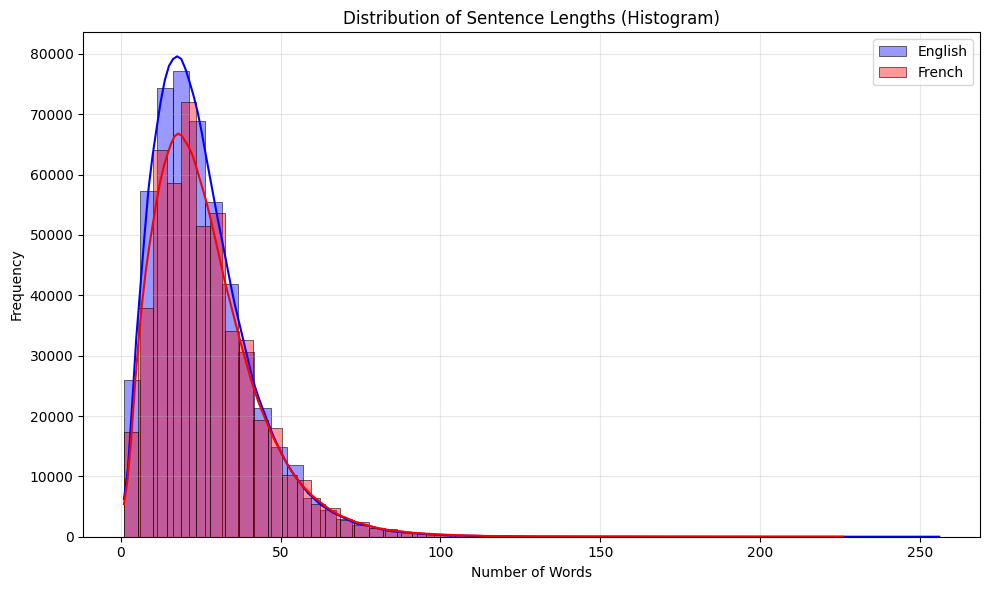

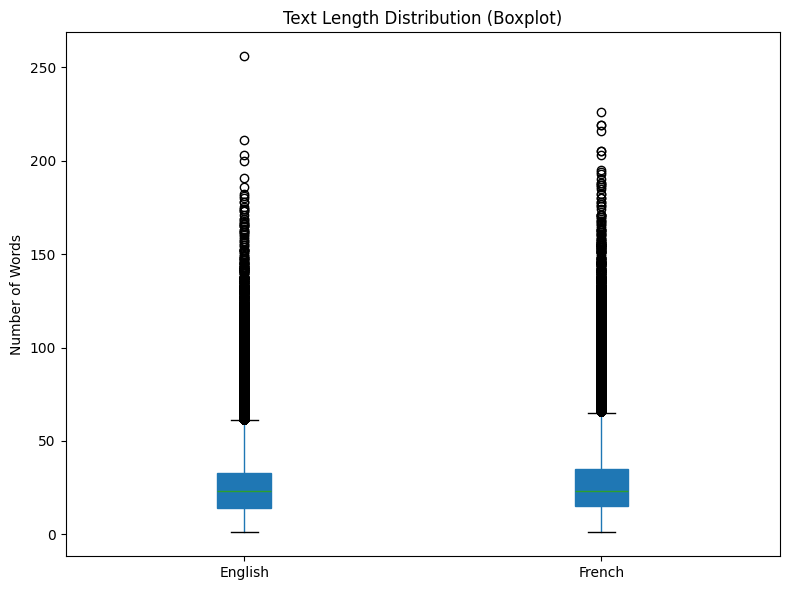

In [14]:
plot_sentence_length_distribution(df, bins)

### Word Clouds

To get a simple viewof  the corpus content, we generate **Word Clouds**. These visualizations scale the size of each word by its frequency in the dataset.

**What we expect to see:**
* **Political Terminology:** Since this is the Europarl corpus, words like "President", "European", "Commission", "Council", "Union" should be very prominent.
* **Cognates:** We should see similar-looking prominent words in both clouds (e.g., "Parliament" vs. "Parlement"), visually confirming the alignment of the dataset.

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_word_clouds(df, sample_size=50000):
    """
    Generates and plots Word Clouds for English and French text.
    Uses .to_image() to fix numpy compatibility issues.
    """
    if df.empty:
        print("No data to plot.")
        return

    # 1. Prepare Text
    if len(df) > sample_size:
        print(f"Sampling {sample_size} sentences for WordCloud generation...")
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df

    # Join text into massive strings (required by WordCloud)
    text_en = " ".join(df_sample['en'].dropna().astype(str))
    text_fr = " ".join(df_sample['fr'].dropna().astype(str))

    # 2. Setup WordCloud Objects
    # English: Blue background or blue color map
    wc_en = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='Blues',
        max_words=100,
        stopwords=set(STOPWORDS)
    ).generate(text_en)

    # French: Red color map (We need to add French stopwords manually or use a library)
    fr_stopwords = set(STOPWORDS).union({
        "le", "la", "les", "de", "des", "du", "un", "une", "et", "est", "en", 
        "que", "qui", "dans", "pour", "sur", "par", "plus", "pas", "ce", "cette", "au"
    })
    
    wc_fr = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='Reds',
        max_words=100,
        stopwords=fr_stopwords
    ).generate(text_fr)

    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # FIX IS HERE: We utilize .to_image() to pass a PIL Image directly
    ax1.imshow(wc_en.to_image(), interpolation='bilinear')
    ax1.set_title("English Word Cloud", fontsize=16, color='navy')
    ax1.axis('off')

    # FIX IS HERE: .to_image()
    ax2.imshow(wc_fr.to_image(), interpolation='bilinear')
    ax2.set_title("French Word Cloud", fontsize=16, color='darkred')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

Sampling 50000 sentences for WordCloud generation...


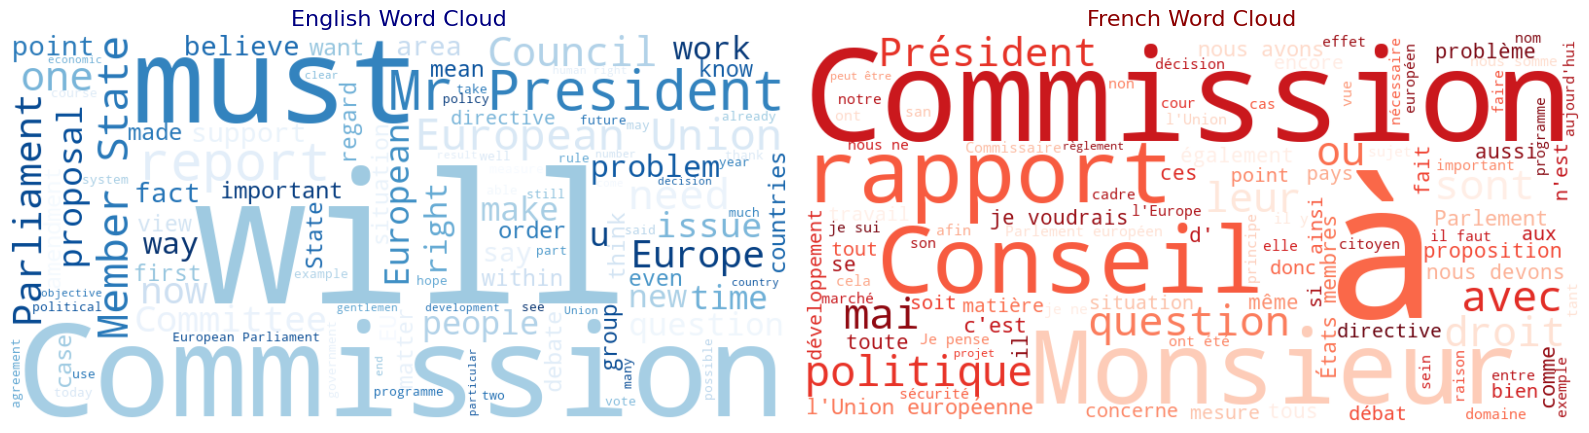

In [16]:
plot_word_clouds(df)

### Visualizing Sentence Length Correlation

We use a scatter plot to visualize the relationship between English and French sentence lengths.

**What to look for:**
* **Linear Correlation:** We expect a strong linear trend where longer English sentences correspond to longer French sentences.
* **The "French Expansion":** Most points should lie slightly above the diagonal ($y=x$), reflecting that French text is generally longer.
* **Outliers:** Points far from the main cluster (e.g., very long English but short French, or vice versa) often indicate alignment errors or garbage data that should be filtered out.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_length_scatter(df, sample_size):
    """
    Generates a scatter plot comparing English vs. French sentence lengths.
    Uses a random sample for performance if the dataset is large.
    """
    if df.empty:
        print("No data to plot.")
        return

    # Ensure lengths are computed
    if 'en_char_len' not in df.columns:
        df['en_char_len'] = df['en'].str.len()
        df['fr_char_len'] = df['fr'].str.len()

    # Sample the data to avoid over-plotting and slow performance
    if len(df) > sample_size:
        plot_df = df.sample(n=sample_size, random_state=42)
        title_suffix = f"(Sample of {sample_size})"
    else:
        plot_df = df
        title_suffix = "(All Data)"

    # --- Setup Plot ---
    plt.figure(figsize=(8, 8))
    
    # Scatter plot
    sns.scatterplot(
        x='en_char_len', 
        y='fr_char_len', 
        data=plot_df, 
        alpha=0.4, 
        color='purple',
        edgecolor=None  # Remove edge color for smoother look with many points
    )
    
    # Add a reference line y=x (no expansion)
    max_val = max(plot_df['en_char_len'].max(), plot_df['fr_char_len'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.6, linewidth=2, label='y=x (1:1 ratio)')
    
    plt.title(f"Sentence Length Correlation: English vs. French {title_suffix}")
    plt.xlabel("English Character Count")
    plt.ylabel("French Character Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("length_correlation.png") # Save just in case you want to use it in the report
    plt.show()

In [18]:
sample_size = 5000

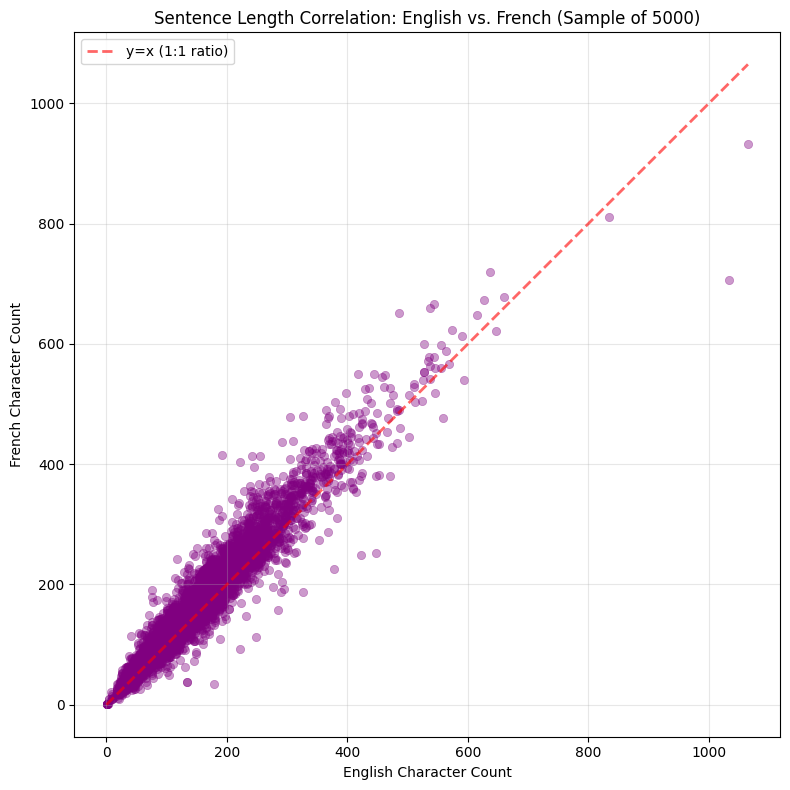

In [19]:
plot_length_scatter(df, sample_size)

### Visualizing Vocabulary Trends: Top Frequent Words

We analyze the most frequent words in both languages to understand the dataset's vocabulary distribution.

**Expected Trends:**
* **Stopwords:** We expect the top ranking words to be functional stopwords (e.g., "the", "of", "le", "de").
* **Domain Specificity:** Since this is Europarl, we might see domain-specific words like "european", "parliament", or "president" appearing relatively high in the list.
* **Noise:** If we see punctuation or weird symbols in the top list, it indicates a need for better cleaning.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pandas as pd

def plot_top_words(df, top_n):
    if df.empty:
        print("No data to plot.")
        return

    # Expanded stop word lists to filter out more noise
    en_stop_words = {
        "the", "a", "an", "and", "or", "but", "if", "then", "is", "are", "was", "to", "of", "in", "on", 
        "it", "that", "this", "with", "as", "for", "we", "i", "be", "have", "which", "not", "by", 
        "will", "has", "mr", "at", "would", "all", "been", "their", "were", "my", "me"
    }
    
    fr_stop_words = {
        "le", "la", "les", "un", "une", "des", "et", "ou", "mais", "si", "est", "sont", "était", "à", 
        "de", "dans", "sur", "il", "ce", "cette", "avec", "comme", "pour", "l", "que", "d", "en", 
        "nous", "du", "qui", "je", "pas", "au", "a", "ne", "qu", "par", "plus", "dans", "se", "sur"
    }

    def get_top_counts(text_series, stop_words):
        # This regex captures words and ignores punctuation
        word_re = re.compile(r"\b\w+\b", re.UNICODE)
        
        all_words = (
            word
            for text in text_series
            for word in word_re.findall(text.lower())
            if word not in stop_words and len(word) > 1 # Added a length check for single-letter noise
        )
        return Counter(all_words).most_common(top_n)

    # Compute Counts
    en_top = get_top_counts(df['en'], en_stop_words)
    fr_top = get_top_counts(df['fr'], fr_stop_words)
    
    df_en_top = pd.DataFrame(en_top, columns=['Word', 'Count'])
    df_fr_top = pd.DataFrame(fr_top, columns=['Word', 'Count'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.barplot(x='Count', y='Word', data=df_en_top, ax=ax1, palette='Blues_r')
    ax1.set_title(f"Top {top_n} English Words")
    
    sns.barplot(x='Count', y='Word', data=df_fr_top, ax=ax2, palette='Reds_r')
    ax2.set_title(f"Top {top_n} French Words")
    
    plt.tight_layout()
    plt.show()

In [35]:
N_top_words = 15

C:\Users\User\AppData\Local\Temp\ipykernel_3748\303876222.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_en_top, ax=ax1, palette='Blues_r')
C:\Users\User\AppData\Local\Temp\ipykernel_3748\303876222.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_fr_top, ax=ax2, palette='Reds_r')


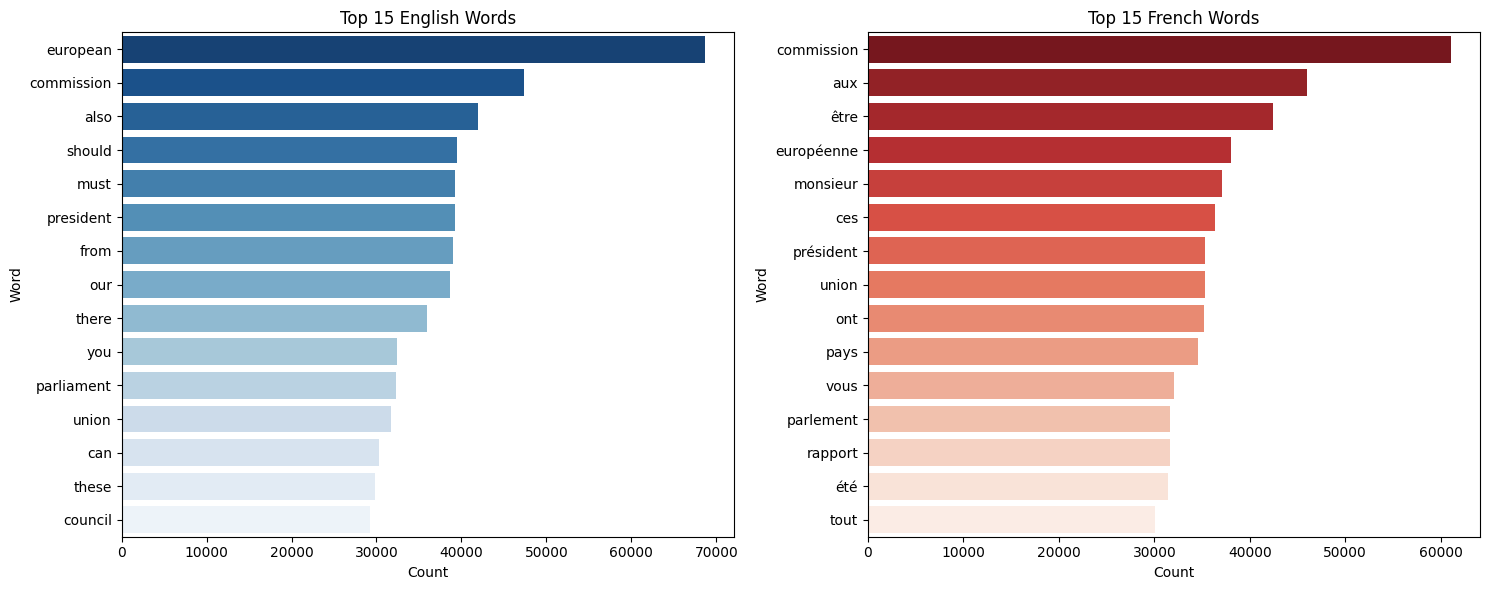

In [36]:
plot_top_words(df, top_n=N_top_words)

### Visualizing Vocabulary Distribution (Zipf's Law)

We verify if our dataset follows **Zipf's Law**, which states that the frequency of any word is inversely proportional to its rank in the frequency table.

**Why checking this is important:**
* **Natural Language Verification:** A straight line on a log-log plot confirms the dataset has the statistical properties of natural human language.
* **Quality Check:** Deviations (e.g., a "staircase" pattern or a flat line) would indicate synthetic data, excessive duplication, or preprocessing errors.

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np

def plot_zipf_law(df):
    """
    Plots the word frequency distribution on a log-log scale to check Zipf's Law.
    Adapted for Pandas DataFrame input.
    """
    if df.empty:
        print("No data to plot.")
        return
    
    # 1. Tokenize and Count (Lightweight for EDA)
    # Using regex to find words, ignoring punctuation
    word_re = re.compile(r"\b\w+\b", re.UNICODE)
    
    def get_freqs(series):
        # Generator expression is memory efficient
        all_words = (word for text in series for word in word_re.findall(text.lower()))
        counts = Counter(all_words)
        # Return frequencies sorted by rank (descending)
        return sorted(counts.values(), reverse=True)

    print("Computing word frequencies... (this may take a moment)")
    en_freqs = get_freqs(df['en'])
    fr_freqs = get_freqs(df['fr'])
    
    # 2. Plotting
    plt.figure(figsize=(10, 6))
    
    # Log-Log Plot
    plt.loglog(en_freqs, label='English', color='blue', linewidth=2, alpha=0.8)
    plt.loglog(fr_freqs, label='French', color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    plt.title("Zipf's Law Check (Log-Log Plot)")
    plt.xlabel("Rank (Log Scale)")
    plt.ylabel("Frequency (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.4)
    
    plt.tight_layout()
    plt.show()

Computing word frequencies... (this may take a moment)


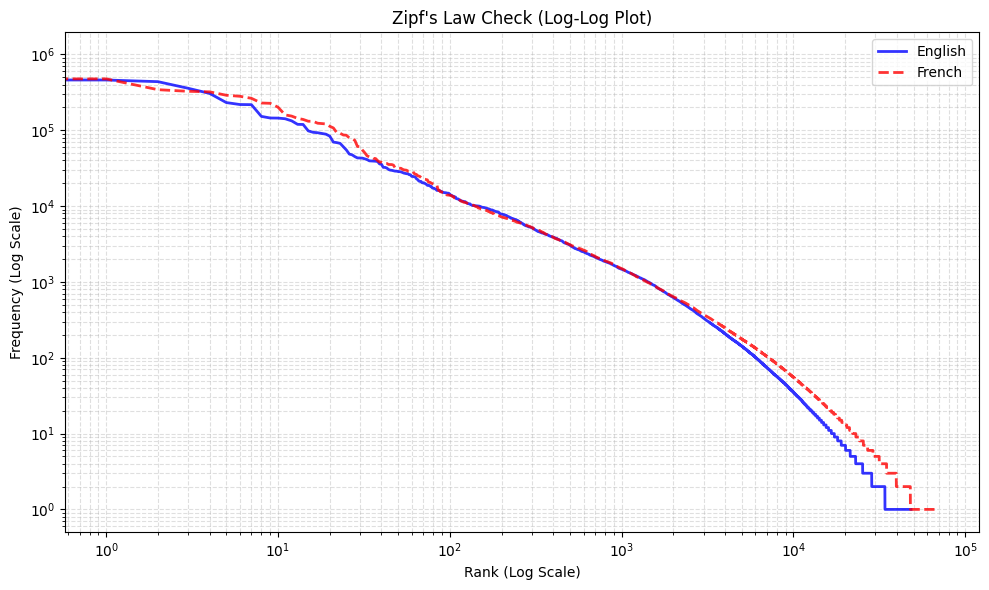

In [24]:
plot_zipf_law(df)

The log–log plot displays a clear, nearly linear trend between rank and frequency, confirming that the word frequency distributions for both English and French are consistent with **Zipf’s law**.

Key observations:
* **Power Law Distribution:** The straight diagonal line indicates that a very small number of unique words occur extremely often (likely function words like "the", "to", "le", "de"), while the vast majority of words appear very rarely (the "long tail").
* **Language Comparison:** Both English and French follow almost identical distributions. The French curve (red dashed line) sits slightly higher and extends further in the lower-frequency region (the tail). This is consistent with French having a richer morphology (more distinct word forms due to conjugations and gender agreements) than English, resulting in a slightly larger vocabulary of unique tokens.
* **Dataset Quality:** The smoothness of the curves suggests the dataset is comprised of natural language without significant artificial noise or duplication artifacts.